In [117]:
import os
os.listdir('./../data/')

['imu_data_3.csv', 'imu_data_1.csv', 'imu_data_2.csv', 'output']

Sampling frequency: 400.01 Hz
Samples per second: 400
Initial accelerometer norm (should be ~9.81 m/s²): 9.82 m/s²
Initial roll (degree): 1.03
Initial pitch (degree): -3.15
Trajectory integration finished.
Trajectory integration finished.


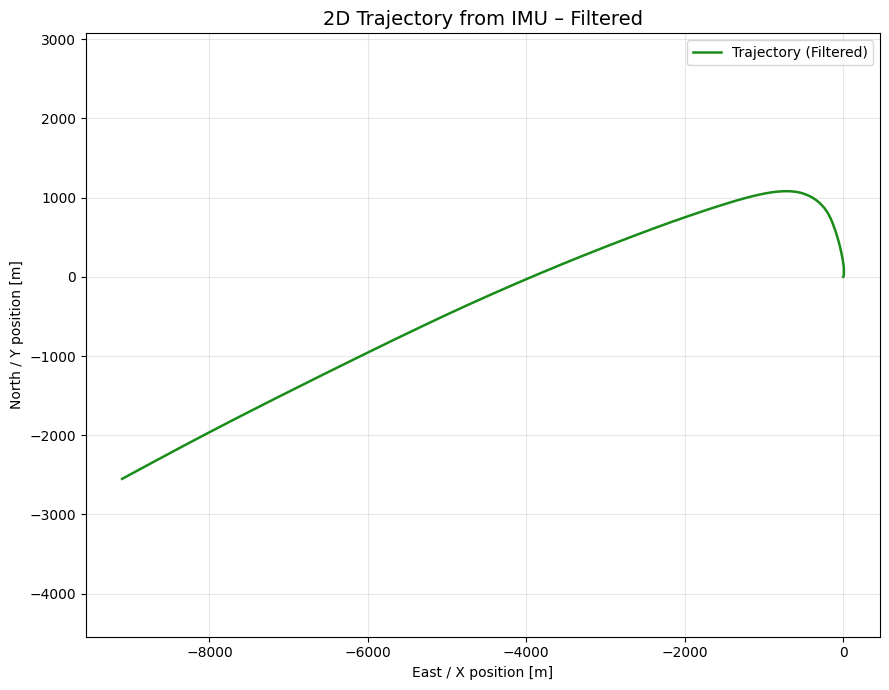

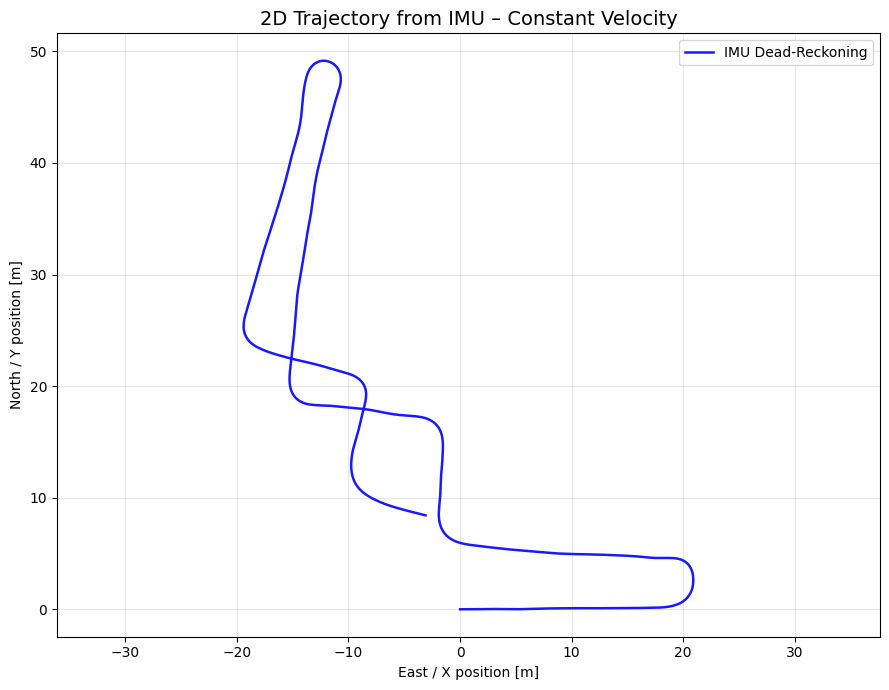

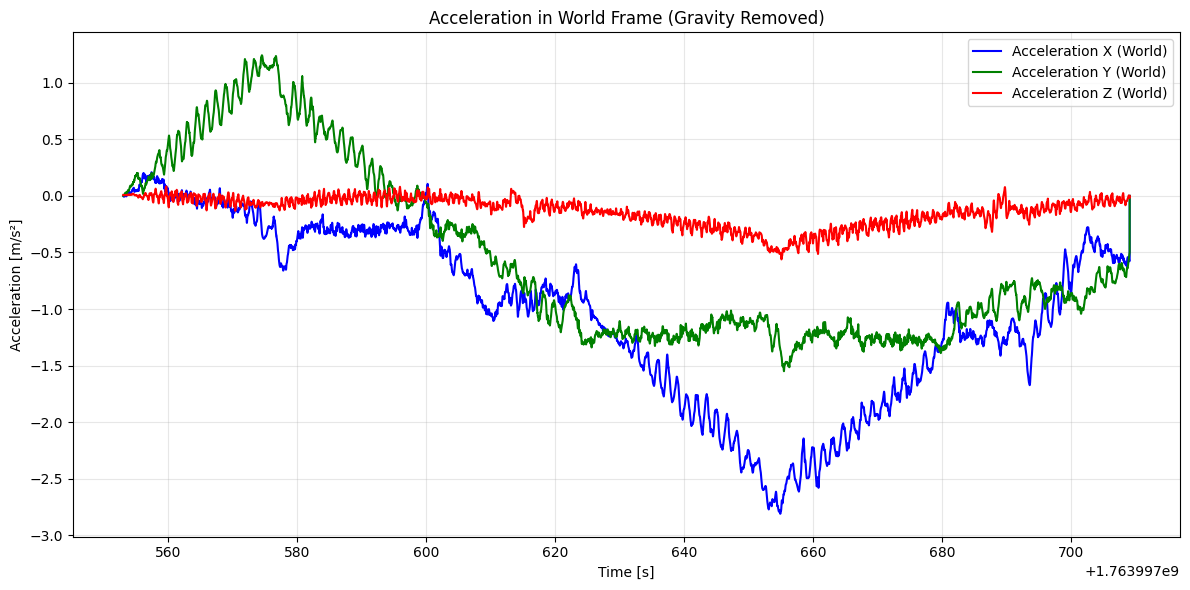

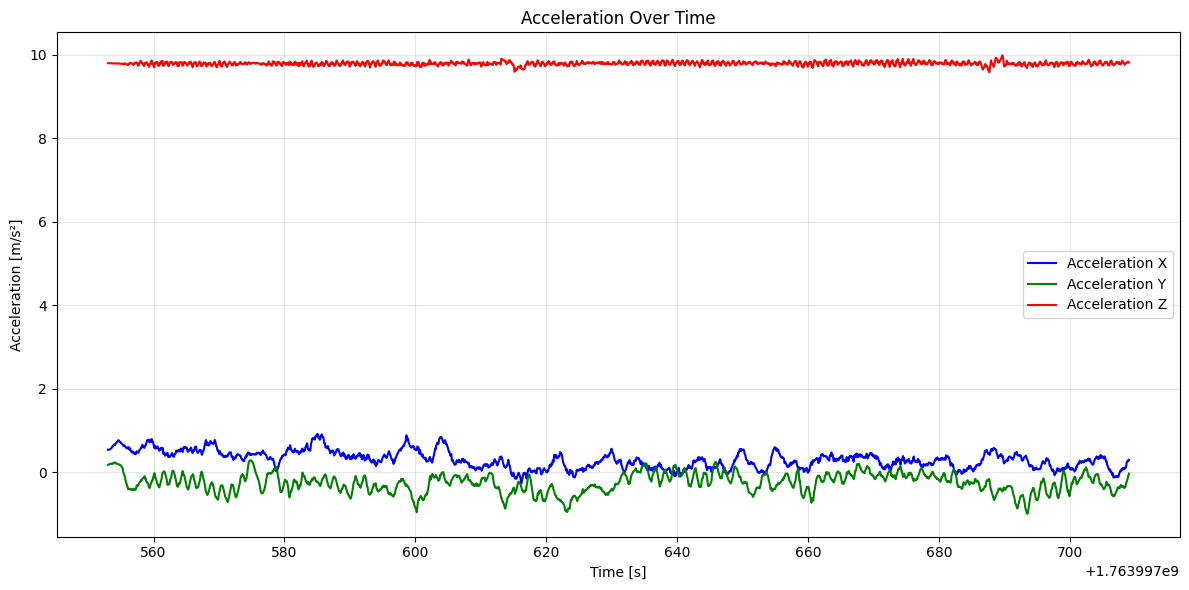

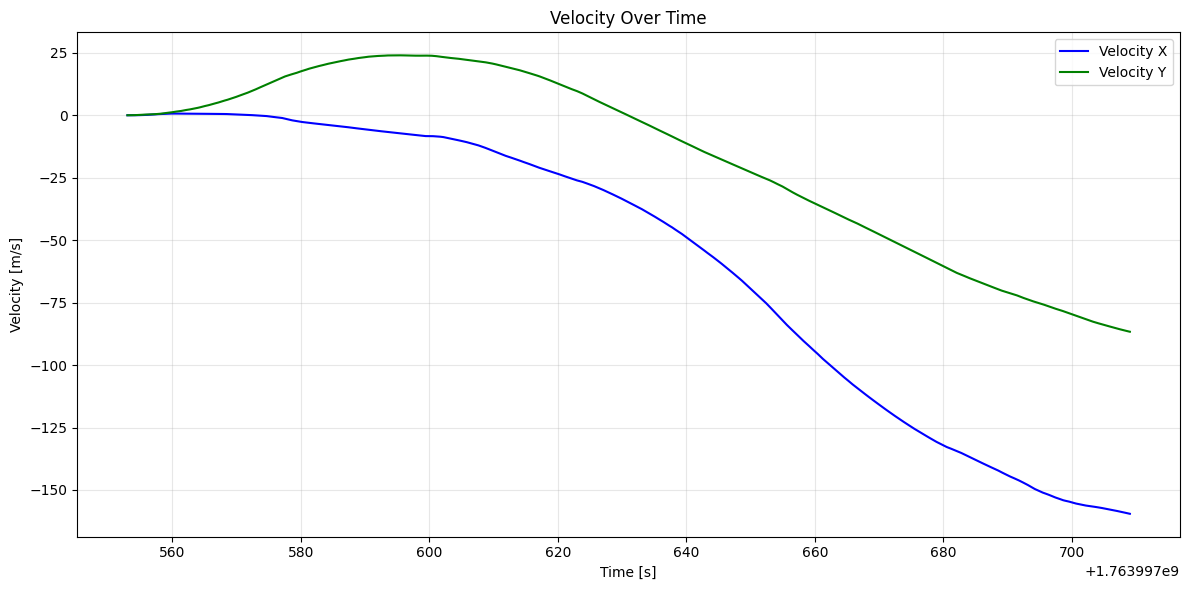

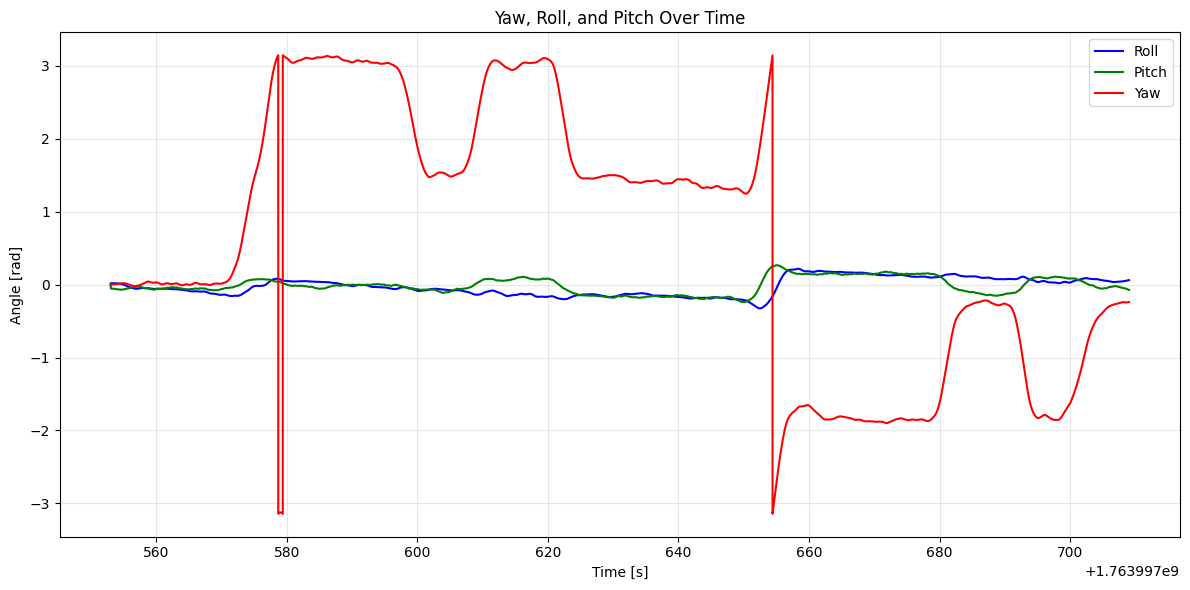

Final position: (-3.09 m, 8.42 m)
Total distance traveled (straight-line): 8.97 m


In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

def process_imu_data(data_path, constant_velocity=False, ratio = 1):
    # -------------------------- Load data --------------------------
    imu_data = pd.read_csv(data_path)

    # Convert nanoseconds to seconds
    t = imu_data['%time'].to_numpy() * 1e-9

    # Raw sensor readings (body frame)
    a_body = imu_data[['field.linear_acceleration.x',
                       'field.linear_acceleration.y',
                       'field.linear_acceleration.z']].to_numpy()

    w_body = imu_data[['field.angular_velocity.x',
                      'field.angular_velocity.y',
                      'field.angular_velocity.z']].to_numpy()

    n = len(t)

    # --------------------- Calculate Sampling Frequency ---------------------
    dt_values = np.diff(t)  # Time differences between consecutive samples
    mean_dt = np.mean(dt_values)  # Mean time difference
    sampling_frequency = 1 / mean_dt  # Frequency in Hz
    samples_per_second = int(np.round(sampling_frequency))  # Number of samples per second
    print(f"Sampling frequency: {sampling_frequency:.2f} Hz")
    print(f"Samples per second: {samples_per_second}")

    # --------------------- Apply Mean Filter ---------------------
    def mean_filter(data, window_size):
        cumsum = np.cumsum(data, axis=0)
        cumsum = np.vstack([np.zeros(data.shape[1]), cumsum])  # Add a zero row at the start
        return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

    # Apply mean filter with window size equal to samples per second
    if samples_per_second > 1:
        a_body = mean_filter(a_body, samples_per_second*ratio)
        w_body = mean_filter(w_body, samples_per_second*ratio)
        t = t[:len(a_body)]  # Adjust time array to match filtered data length
        n = len(t)

    # --------------------- Accelerometer calibration ---------------------
    accel_bias  = np.array([-0.0346, 0.0606, -0.0050])   # m/s²
    accel_scale = np.array([8e-4, 1e-4, 51e-5])
    # accel_bias  = np.zeros(3)   # m/s²
    # accel_scale = np.zeros(3)

    a_body_cal = (1+accel_scale) * (a_body - accel_bias)   # calibrated body acceleration

    # --------------------- Initial attitude from accelerometer ---------------------
    a_init = a_body_cal[0]  # First sample indicates the world frame
    g_norm = np.linalg.norm(a_init) 
    print(f"Initial accelerometer norm (should be ~9.81 m/s²): {g_norm:.2f} m/s²")
    roll0  = np.arcsin(a_init[1] / g_norm)  # Roll based on g_norm
    print(f"Initial roll (degree): {roll0*180/np.pi:.2f}")
    pitch0 = np.arcsin(-a_init[0] / g_norm)
    print(f"Initial pitch (degree): {pitch0*180/np.pi:.2f}")
    yaw0   = 0.0

    initial_rotation = R.from_euler('xyz', [roll0, pitch0, yaw0])

    # --------------------- Integration loop ---------------------
    trajectory = np.zeros((n, 2))   # only X-Y position
    trajectory_const_vel = np.zeros((n, 2))   # only X-Y position

    velocity   = np.zeros((n, 2))  # horizontal velocity in local frame
    attitude   = initial_rotation  # current body → local rotation
    GRAVITY    = np.array([0.0, 0.0, 9.81])

    theta = np.zeros(n)  # Store orientation angle (yaw) over time
    roll = np.zeros(n)   # Store roll angle over time
    pitch = np.zeros(n)  # Store pitch angle over time

    a_world_no_g = np.zeros((n, 3))  # Store acceleration in world frame without gravity

    for i in range(n-1):
        dt = t[i+1] - t[i]

        # --- 1. Update orientation using raw gyroscope only ---
        angular_vel = w_body[i]                     # rad/s, no bias subtraction
        delta_rot   = R.from_rotvec(angular_vel * dt)
        attitude    = attitude * delta_rot           # new body → local rotation

        # Extract yaw, roll, pitch angles from attitude
        euler_angles = attitude.as_euler('xyz', degrees=False)
        roll[i+1], pitch[i+1], theta[i+1] = euler_angles

        # Rotation matrix (3×3)
        R_bl = attitude.as_matrix()                  # body to local

        # --- 2. Transform acceleration to local frame and remove gravity ---
        a_local = R_bl @ a_body_cal[i]               # includes gravity
        a_local_no_g = a_local - GRAVITY             # gravity-free in local frame
        a_world_no_g[i] = a_local_no_g

        # --- 3. Keep only horizontal components (X-Y) ---
        a_xy = a_local_no_g[:2]

        # --- 4. Integrate velocity and position (trapezoidal = more accurate) ---
        v_old = velocity[i].copy()
        velocity[i+1] = velocity[i] + a_xy * dt
        trajectory[i+1] = trajectory[i] + (v_old + velocity[i+1]) / 2 * dt

        if constant_velocity:
            # Map unit velocity in body frame to world frame
            body_unit_velocity = np.array([1, 0, 0])  # Unit velocity in body frame (X-axis)
            world_velocity = R_bl @ body_unit_velocity  # Map to world frame
            trajectory_const_vel[i+1] = trajectory_const_vel[i] + world_velocity[:2] * dt
        else:
            trajectory_const_vel[i+1] = trajectory_const_vel[i] + (np.array([1, 0]) @ a_body_cal[i]) * dt

    print("Trajectory integration finished.")

    # --------------------- Plot Trajectories ---------------------
    plt.figure(figsize=(9, 7))
    plt.plot(trajectory[:, 0], trajectory[:, 1], 'g-', linewidth=1.8, alpha=0.9, label='Trajectory (Filtered)')
    plt.xlabel('East / X position [m]')
    plt.ylabel('North / Y position [m]')
    plt.title('2D Trajectory from IMU – Filtered', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9, 7))
    plt.plot(trajectory_const_vel[:, 0], trajectory_const_vel[:, 1], 'b-', linewidth=1.8, alpha=0.9, label='IMU Dead-Reckoning')
    plt.xlabel('East / X position [m]')
    plt.ylabel('North / Y position [m]')
    plt.title('2D Trajectory from IMU – Constant Velocity', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------------------- Plot Acceleration in World Frame ---------------------
    plt.figure(figsize=(12, 6))
    plt.plot(t, a_world_no_g[:, 0], label='Acceleration X (World)', color='blue')
    plt.plot(t, a_world_no_g[:, 1], label='Acceleration Y (World)', color='green')
    plt.plot(t, a_world_no_g[:, 2], label='Acceleration Z (World)', color='red')
    plt.xlabel('Time [s]')
    plt.ylabel('Acceleration [m/s²]')
    plt.title('Acceleration in World Frame (Gravity Removed)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --------------------- Plot Acceleration and Velocity ---------------------
    plt.figure(figsize=(12, 6))
    plt.plot(t, a_body_cal[:, 0], label='Acceleration X', color='blue')
    plt.plot(t, a_body_cal[:, 1], label='Acceleration Y', color='green')
    plt.plot(t, a_body_cal[:, 2], label='Acceleration Z', color='red')
    plt.xlabel('Time [s]')
    plt.ylabel('Acceleration [m/s²]')
    plt.title('Acceleration Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(t, velocity[:, 0], label='Velocity X', color='blue')
    plt.plot(t, velocity[:, 1], label='Velocity Y', color='green')
    plt.xlabel('Time [s]')
    plt.ylabel('Velocity [m/s]')
    plt.title('Velocity Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --------------------- Plot Yaw, Roll, Pitch ---------------------
    plt.figure(figsize=(12, 6))
    plt.plot(t, roll, label='Roll', color='blue')
    plt.plot(t, pitch, label='Pitch', color='green')
    plt.plot(t, theta, label='Yaw', color='red')
    plt.xlabel('Time [s]')
    plt.ylabel('Angle [rad]')
    plt.title('Yaw, Roll, and Pitch Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Optional: print final displacement
    print(f"Final position: ({trajectory_const_vel[-1,0]:.2f} m, {trajectory_const_vel[-1,1]:.2f} m)")
    print(f"Total distance traveled (straight-line): {np.linalg.norm(trajectory_const_vel[-1]):.2f} m")

# Example usage
process_imu_data('./../data/imu_data_1.csv', constant_velocity=True, ratio = 2)

Sampling frequency: 400.01 Hz
Samples per second: 400
Initial accelerometer norm (should be ~9.81 m/s²): 9.82 m/s²
Initial roll (degree): 1.17
Initial pitch (degree): -3.58
Trajectory integration finished.
Trajectory integration finished.


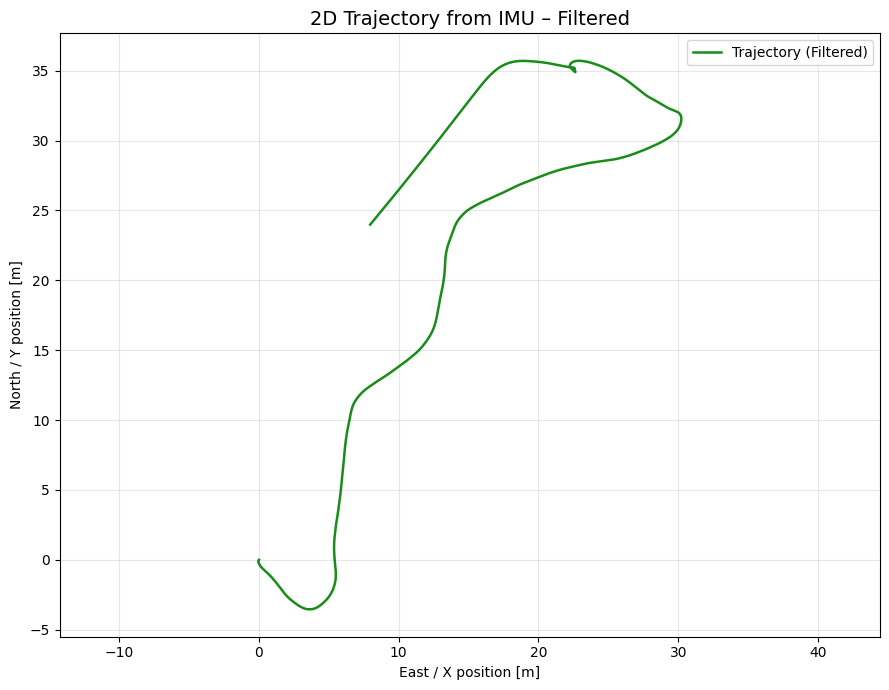

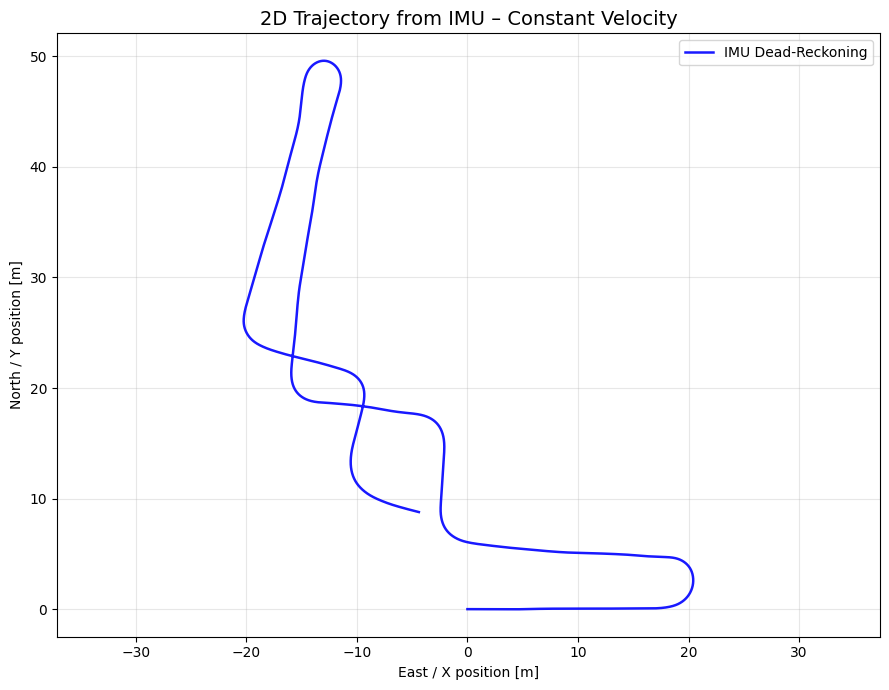

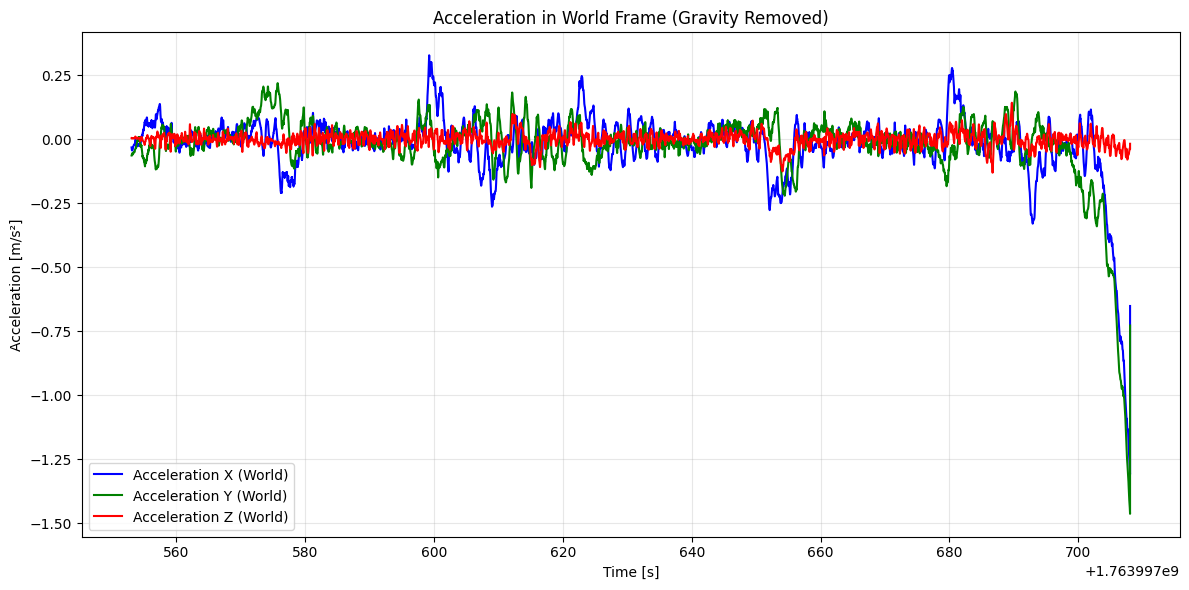

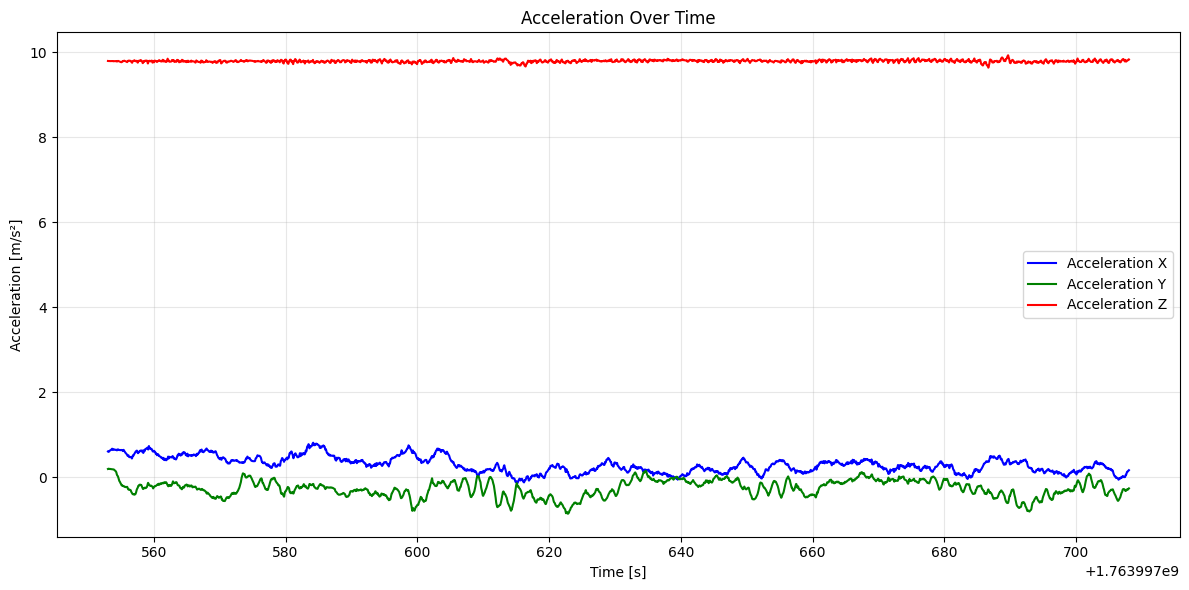

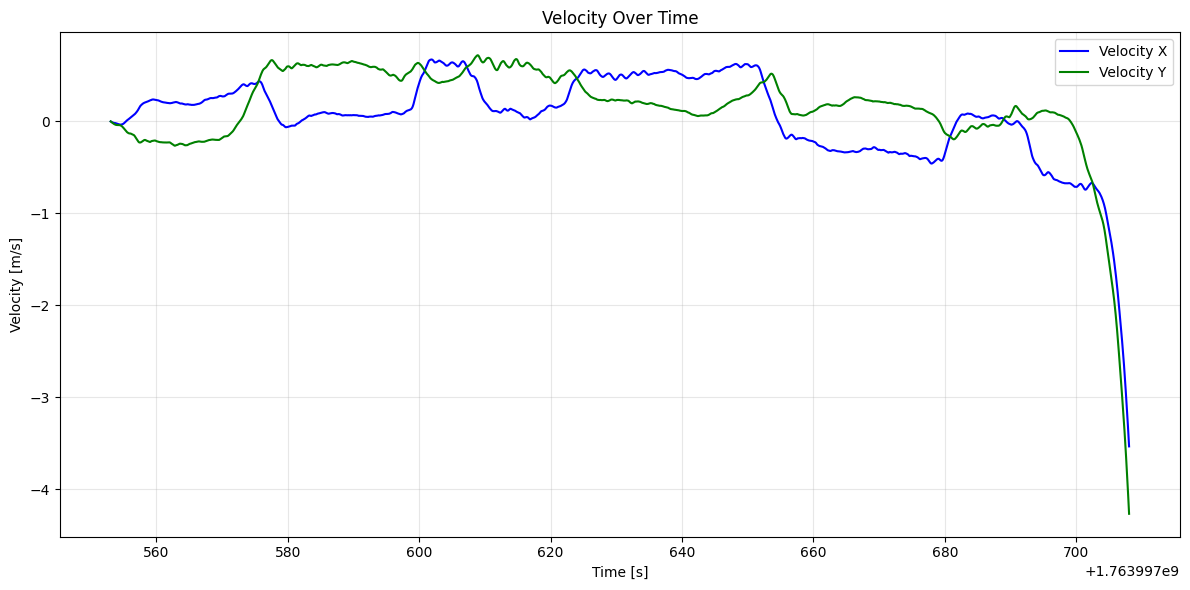

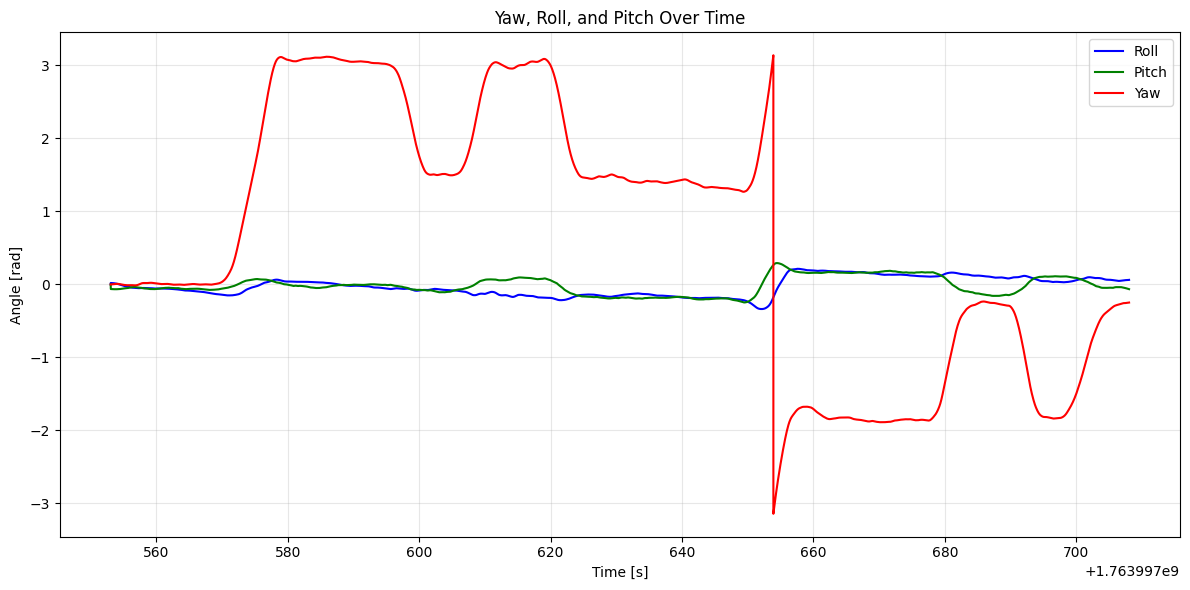

Final position: (-4.39 m, 8.78 m)
Total distance traveled (straight-line): 9.82 m


In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from scipy.signal import butter, filtfilt

def process_imu_data(data_path, constant_velocity=False, ratio = 1):
    # -------------------------- Load data --------------------------
    imu_data = pd.read_csv(data_path)

    # Convert nanoseconds to seconds
    t = imu_data['%time'].to_numpy() * 1e-9

    # Raw sensor readings (body frame)
    a_body = imu_data[['field.linear_acceleration.x',
                       'field.linear_acceleration.y',
                       'field.linear_acceleration.z']].to_numpy()

    w_body = imu_data[['field.angular_velocity.x',
                      'field.angular_velocity.y',
                      'field.angular_velocity.z']].to_numpy()

    n = len(t)

    # --------------------- Calculate Sampling Frequency ---------------------
    dt_values = np.diff(t)  # Time differences between consecutive samples
    mean_dt = np.mean(dt_values)  # Mean time difference
    sampling_frequency = 1 / mean_dt  # Frequency in Hz
    samples_per_second = int(np.round(sampling_frequency))  # Number of samples per second
    print(f"Sampling frequency: {sampling_frequency:.2f} Hz")
    print(f"Samples per second: {samples_per_second}")

    # --------------------- Apply Mean Filter ---------------------
    def mean_filter(data, window_size):
        cumsum = np.cumsum(data, axis=0)
        cumsum = np.vstack([np.zeros(data.shape[1]), cumsum])  # Add a zero row at the start
        return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

    # Apply mean filter with window size equal to samples per second
    if samples_per_second > 1:
        a_body = mean_filter(a_body, samples_per_second*ratio)
        w_body = mean_filter(w_body, samples_per_second*ratio)
        t = t[:len(a_body)]  # Adjust time array to match filtered data length
        n = len(t)

    # --------------------- Accelerometer calibration ---------------------
    accel_bias  = np.array([-0.0346, 0.0606, -0.0050])   # m/s²
    accel_scale = np.array([8e-4, 1e-4, 51e-5])
    # accel_bias  = np.zeros(3)   # m/s²
    # accel_scale = np.zeros(3)

    a_body_cal = (1+accel_scale) * (a_body - accel_bias)   # calibrated body acceleration

    # --------------------- Initial attitude from accelerometer ---------------------
    a_init = a_body_cal[0]  # First sample indicates the world frame
    g_norm = np.linalg.norm(a_init) 
    print(f"Initial accelerometer norm (should be ~9.81 m/s²): {g_norm:.2f} m/s²")
    roll0  = np.arcsin(a_init[1] / g_norm)  # Roll based on g_norm
    print(f"Initial roll (degree): {roll0*180/np.pi:.2f}")
    pitch0 = np.arcsin(-a_init[0] / g_norm)
    print(f"Initial pitch (degree): {pitch0*180/np.pi:.2f}")
    yaw0   = 0.0

    initial_rotation = R.from_euler('xyz', [roll0, pitch0, yaw0])

    # --------------------- Integration loop ---------------------
    trajectory = np.zeros((n, 2))   # only X-Y position
    trajectory_const_vel = np.zeros((n, 2))   # only X-Y position

    velocity   = np.zeros((n, 2))  # horizontal velocity in local frame
    attitude   = initial_rotation  # current body → local rotation
    GRAVITY    = np.array([0.0, 0.0, 9.81])

    theta = np.zeros(n)  # Store orientation angle (yaw) over time
    roll = np.zeros(n)   # Store roll angle over time
    pitch = np.zeros(n)  # Store pitch angle over time

    a_world_no_g = np.zeros((n, 3))  # Store acceleration in world frame without gravity

    # --------------------- Low-Pass Filter Design ---------------------
    nyquist = 0.9 * sampling_frequency
    cutoff = 0.1 / nyquist  # Cutoff frequency (normalized)
    b, a = butter(1, cutoff, btype='high')
    R_bl_list = []  # To store rotation matrices for each time step
    # --------------------- Integration ---------------------
    for i in range(n-1):
        dt = t[i+1] - t[i]

        # --- 1. Update orientation using raw gyroscope only ---
        angular_vel = w_body[i]                     # rad/s, no bias subtraction
        delta_rot   = R.from_rotvec(angular_vel * dt)
        attitude    = attitude * delta_rot           # new body → local rotation

        # Extract yaw, roll, pitch angles from attitude
        euler_angles = attitude.as_euler('xyz', degrees=False)
        roll[i+1], pitch[i+1], theta[i+1] = euler_angles

        # Rotation matrix (3×3)
        R_bl = attitude.as_matrix()                  # body to local
        R_bl_list.append(R_bl)
        # --- 2. Transform acceleration to local frame and remove gravity ---
        a_local = R_bl @ a_body_cal[i]               # includes gravity
        a_local_no_g = a_local - GRAVITY             # gravity-free in local frame
        a_world_no_g[i] = a_local_no_g

    # Apply low-pass filter to remove drift
    acc_out_temp = a_world_no_g.copy()
    a_world_no_g = filtfilt(b, a, a_world_no_g, axis=0)

    # Recalculate trajectory using filtered acceleration
    for i in range(n-1):
        dt = t[i+1] - t[i]

        # --- 3. Keep only horizontal components (X-Y) ---
        a_xy = a_world_no_g[i, :2]

        # --- 4. Integrate velocity and position (trapezoidal = more accurate) ---
        v_old = velocity[i].copy()
        velocity[i+1] = velocity[i] + a_xy * dt
        trajectory[i+1] = trajectory[i] + (v_old + velocity[i+1]) / 2 * dt

        if constant_velocity:
            # Map unit velocity in body frame to world frame
            body_unit_velocity = np.array([1, 0, 0])  # Unit velocity in body frame (X-axis)
            world_velocity = R_bl_list[i] @ body_unit_velocity  # Map to world frame
            trajectory_const_vel[i+1] = trajectory_const_vel[i] + world_velocity[:2] * dt
        else:
            trajectory_const_vel[i+1] = trajectory_const_vel[i] + (np.array([1, 0]) @ a_body_cal[i]) * dt

    print("Trajectory integration finished.")

    # --------------------- Plot Trajectories ---------------------
    plt.figure(figsize=(9, 7))
    plt.plot(trajectory[:, 0], trajectory[:, 1], 'g-', linewidth=1.8, alpha=0.9, label='Trajectory (Filtered)')
    plt.xlabel('East / X position [m]')
    plt.ylabel('North / Y position [m]')
    plt.title('2D Trajectory from IMU – Filtered', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9, 7))
    plt.plot(trajectory_const_vel[:, 0], trajectory_const_vel[:, 1], 'b-', linewidth=1.8, alpha=0.9, label='IMU Dead-Reckoning')
    plt.xlabel('East / X position [m]')
    plt.ylabel('North / Y position [m]')
    plt.title('2D Trajectory from IMU – Constant Velocity', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------------------- Plot Acceleration in World Frame ---------------------
    plt.figure(figsize=(12, 6))
    plt.plot(t, a_world_no_g[:, 0], label='Acceleration X (World)', color='blue')
    plt.plot(t, a_world_no_g[:, 1], label='Acceleration Y (World)', color='green')
    plt.plot(t, a_world_no_g[:, 2], label='Acceleration Z (World)', color='red')
    plt.xlabel('Time [s]')
    plt.ylabel('Acceleration [m/s²]')
    plt.title('Acceleration in World Frame (Gravity Removed)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --------------------- Plot Acceleration and Velocity ---------------------
    plt.figure(figsize=(12, 6))
    plt.plot(t, a_body_cal[:, 0], label='Acceleration X', color='blue')
    plt.plot(t, a_body_cal[:, 1], label='Acceleration Y', color='green')
    plt.plot(t, a_body_cal[:, 2], label='Acceleration Z', color='red')
    plt.xlabel('Time [s]')
    plt.ylabel('Acceleration [m/s²]')
    plt.title('Acceleration Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(t, velocity[:, 0], label='Velocity X', color='blue')
    plt.plot(t, velocity[:, 1], label='Velocity Y', color='green')
    plt.xlabel('Time [s]')
    plt.ylabel('Velocity [m/s]')
    plt.title('Velocity Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --------------------- Plot Yaw, Roll, Pitch ---------------------
    plt.figure(figsize=(12, 6))
    plt.plot(t, roll, label='Roll', color='blue')
    plt.plot(t, pitch, label='Pitch', color='green')
    plt.plot(t, theta, label='Yaw', color='red')
    plt.xlabel('Time [s]')
    plt.ylabel('Angle [rad]')
    plt.title('Yaw, Roll, and Pitch Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Optional: print final displacement
    print(f"Final position: ({trajectory_const_vel[-1,0]:.2f} m, {trajectory_const_vel[-1,1]:.2f} m)")
    print(f"Total distance traveled (straight-line): {np.linalg.norm(trajectory_const_vel[-1]):.2f} m")
    return acc_out_temp, a_world_no_g

# Example usage
acc_out_temp, a_world_no_g = process_imu_data('./../data/imu_data_1.csv', constant_velocity=True, ratio = 3)

/tmp/ipykernel_93979/887653867.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(frequencies, 20 * np.log10(abs(h)), 'b')


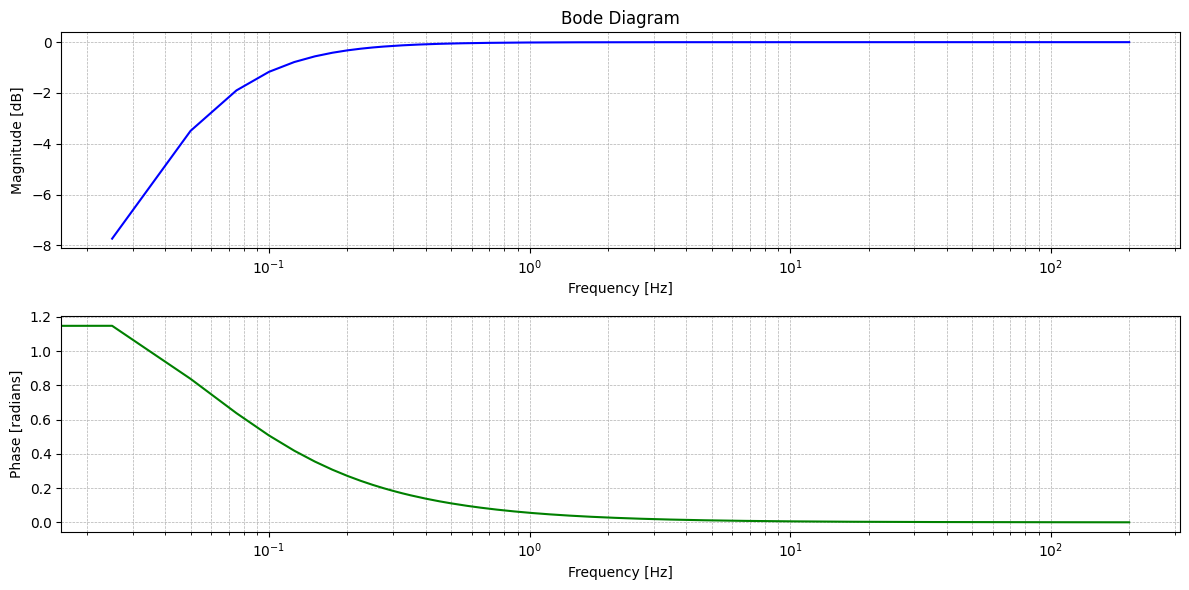

In [144]:
from scipy.signal import freqz
import matplotlib.pyplot as plt

def plot_bode_diagram(b, a, sampling_frequency):
    w, h = freqz(b, a, worN=8000)
    frequencies = w * sampling_frequency / (2 * np.pi)  # Convert to Hz

    plt.figure(figsize=(12, 6))

    # Magnitude plot
    plt.subplot(2, 1, 1)
    plt.semilogx(frequencies, 20 * np.log10(abs(h)), 'b')
    plt.title('Bode Diagram')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.grid(which='both', linestyle='--', linewidth=0.5)

    # Phase plot
    plt.subplot(2, 1, 2)
    plt.semilogx(frequencies, np.angle(h), 'g')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Phase [radians]')
    plt.grid(which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

# Example usage
nyquist = 0.9 * 400
cutoff = 0.1/nyquist  # Cutoff frequency (normalized)
b, a = butter(1, cutoff, btype='high')
plot_bode_diagram(b, a, 400)

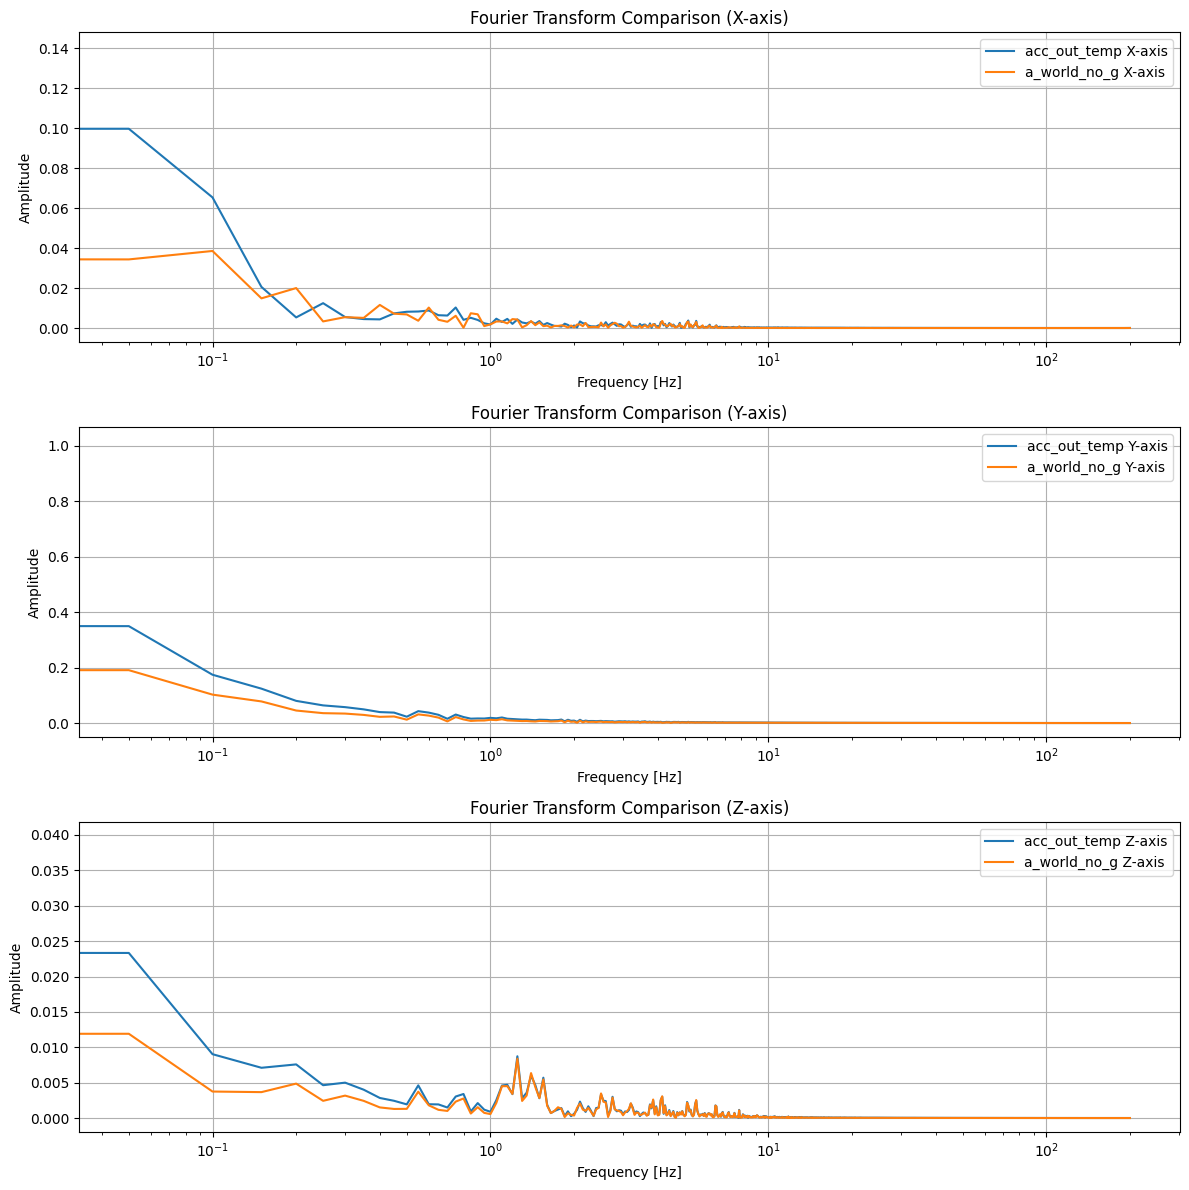

In [145]:
from scipy.fft import fft, fftfreq

def plot_fourier_transform_combined(data1, data2, sampling_frequency, title, t0=None, t1=None):
    if t0 is not None and t1 is not None:
        start_idx = int(t0 * sampling_frequency)
        end_idx = int(t1 * sampling_frequency)
        data1 = data1[start_idx:end_idx]
        data2 = data2[start_idx:end_idx]

    n1 = len(data1)
    n2 = len(data2)

    plt.figure(figsize=(12, 12))

    for i, axis in enumerate(['X', 'Y', 'Z']):
        yf1 = fft(data1[:, i])
        xf1 = fftfreq(n1, 1 / sampling_frequency)[:n1 // 2]

        yf2 = fft(data2[:, i])
        xf2 = fftfreq(n2, 1 / sampling_frequency)[:n2 // 2]

        plt.subplot(3, 1, i + 1)
        plt.semilogx(xf1, 2.0 / n1 * np.abs(yf1[:n1 // 2]), label=f'acc_out_temp {axis}-axis')
        plt.semilogx(xf2, 2.0 / n2 * np.abs(yf2[:n2 // 2]), label=f'a_world_no_g {axis}-axis')
        plt.title(f'{title} ({axis}-axis)')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Amplitude')
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
sampling_frequency = 400  # Replace with the actual sampling frequency
t0, t1 = 0, 20  # Replace with the desired time window in seconds

# Combined Fourier Transform for acc_out_temp and a_world_no_g
plot_fourier_transform_combined(acc_out_temp, a_world_no_g, sampling_frequency, 'Fourier Transform Comparison', t0, t1)